<a href="https://colab.research.google.com/github/Oladapo01/finalProject/blob/main/BERTModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install transformers
!pip install spacy
!pip install torch
!pip install datasets
!pip install translate

In [2]:
!pip install accelerate>=0.21.0

In [3]:
import transformers
import accelerate
print("Transformers version:", transformers.__version__)
print("Accelerate version:", accelerate.__version__)


Transformers version: 4.40.1
Accelerate version: 0.29.3


In [4]:
!pip install fasttext


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227139 sha256=ae1475a0f6a520da2353a6f73ed97a245ed2fc7b43fbeb4e45afb612c76d4eab
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [5]:
!pip install https://huggingface.co/latincy/la_core_web_lg/resolve/main/la_core_web_lg-any-py3-none-any.whl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.6/234.6 MB 4.6 MB/s eta 0:00:00


In [6]:
import spacy
import fasttext.util
import os
import re
import la_core_web_lg
from transformers import ProgressCallback
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
import sys
import torch.nn as nn
import psutil
import torch
from google.colab import drive
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score




drive.mount('/content/drive', force_remount=True)
latin_text_dir = '/content/drive/MyDrive/data/latin_text'
lemmatizer_dir = '/content/drive/MyDrive/data/lemmatizer'
subwords_dir = '/content/drive/MyDrive/data/subwords'
if not os.path.exists("lid.176.bin"):
    fasttext.util.download_model("lid.176.bin", if_exists="ignore")

class PrintCallback(ProgressCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        print("Training is starting")

    def on_train_end(self, args, state, control, **kwargs):
        print("Training is finished")

    def on_epoch_begin(self, args, state, control, **kwargs):
        print(f"Starting epoch {state.epoch}")

    def on_log(self, args, state, control, logs, **kwargs):
        print(logs)



class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    @property
    def features(self):
        if hasattr(self.dataset, "features"):
            return self.dataset.features
        elif hasattr(self.dataset, "info") and hasattr(self.dataset.info, "features"):
            return self.dataset.info.features
        else:
            return None

    @property
    def num_rows(self):
        return len(self.dataset)



class Accuracy:
    def __init__(self, ignore_index=-1):
        self.ignore_index = ignore_index
        self.reset()

    def add_batch(self, predictions, references):
        predicted_labels = torch.argmax(predictions, dim=-1)

        mask = references != self.ignore_index
        correct_predictions = (predicted_labels == references) & mask
        self.correct += correct_predictions.sum().item()
        self.total_predictions += mask.sum().item()

    def reset(self):
        self.correct = 0
        self.total_predictions = 0

    def update(self, logits, labels):
        with torch.no_grad():
            if logits.dim() == 2:
                predictions = torch.argmax(logits, dim=-1)
            else:
                predictions = logits.squeeze()
            mask = (labels != self.ignore_index)
            self.correct += (predictions[mask] == labels[mask]).sum().item()
            self.total_predictions += mask.sum().item()

    def compute(self):
        if self.total_predictions == 0:
            return 0.0
        return self.correct / self.total_predictions



def safe_division(n, d):
    return n / d if d else 0





class AccuracyMetric:
    def __init__(self, ignore_index=-1):
        self.ignore_index = ignore_index
        self.reset()
        self.predictions = []
        self.references = []

    def add_batch(self, predictions, references):
        if predictions.dim() == 1:
            predicted_labels = predictions
        else:
            predicted_labels = torch.argmax(predictions, dim=1)
        self.correct += (predicted_labels == references).sum().item()
        self.total += references.nelement()


    def reset(self):
        self.correct = 0
        self.total = 0
        self.predictions = []
        self.references = []


    def update(self, logits, labels):
        with torch.no_grad():
            predictions = logits.argmax(dim=-1)
            mask = (labels != self.ignore_index)
            filtered_predictions = predictions[mask]
            filtered_labels = labels[mask]
            self.predictions.extend(filtered_predictions.cpu().numpy())
            self.references.extend(filtered_labels.cpu().numpy())
    def compute(self):
        if not self.references:
          return {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}

        accuracy = safe_division(self.correct, self.total)
        precision = precision_score(self.references, self.predictions, average='weighted', zero_division=0)
        recall = recall_score(self.references, self.predictions, average='weighted', zero_division=0)
        f1 = f1_score(self.references, self.predictions, average='weighted', zero_division=0)
        return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}





class Seq2SeqCrossEntropyLoss(nn.Module):
    def __init__(self, ignore_index=-100):
        super().__init__()
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=ignore_index)

    def forward(self, logits, labels):
        # Flatten the tensors to [batch_size * sequence_length, num_classes]
        logits_flat = logits.view(-1, logits.size(-1))
        labels_flat = labels.view(-1)
        return self.loss_fn(logits_flat, labels_flat)


Mounted at /content/drive


In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
%env TORCH_USE_CUDA_DSA=1


env: TORCH_USE_CUDA_DSA=1


In [7]:
import spacy
import fasttext.util
import os
import re
import la_core_web_lg
from transformers import BertTokenizer, AutoModelForSequenceClassification, BertModel, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset, Dataset, load_metric
from sklearn.model_selection import train_test_split
import sys
import psutil
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from tqdm import tqdm






%env TORCH_USE_CUDA_DSA=1

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# This tells spaCy to use the GPU if it's available.
spacy.prefer_gpu()

class LatinBERTTrainer:
    def __init__(self, latin_text_dir, lemmatizer_dir, subwords_dir, model_name="bert-base-multilingual-cased", output_dir="/data", tokenizer_dir=None, batch_size=2):
        """Initializes the LatinBERTTrainer.

        Args:
            latin_text_dir (str): Directory containing Latin text files.
            lemmatizer_dir (str): Directory for lemmatizer data.
            subwords_dir (str): Directory for subwords data.
            model_name (str, optional): Pre-trained model name. Defaults to "bert-base-multilingual-cased".
            output_dir (str, optional): Output directory. Defaults to "/data".
            tokenizer_dir (str, optional): Directory for tokenizer data. Defaults to None.
            batch_size (int, optional): Batch size for training. Defaults to 16.
        """
        self.model_name = model_name
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2200).to(self.device)
        self.tokenizer_dir = tokenizer_dir if tokenizer_dir else '/content/drive/MyDrive/tokenized_data'
        self.batch_size = batch_size
        self.training_args = TrainingArguments(
            output_dir=output_dir,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            num_train_epochs=50,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            logging_dir=f"{output_dir}/logs",
            logging_steps=1,
            save_steps=10,
            do_train=True,
            do_eval=True,
            load_best_model_at_end=True,
            metric_for_best_model= "accuracy",
            save_total_limit=2,
        )

        encoder_layers = self.model.bert.encoder.layer
        for layer in encoder_layers:
          layer.attention.self.dropout = nn.Dropout(p=0.2)
          layer.output.dropout = nn.Dropout(p=0.2)
        self.trainer = None
        # Attempt to load the tokenizer from a specified directory
        if os.path.exists(self.tokenizer_dir):
            try:
                self.tokenized_data = self.load_tokenized_data(self.tokenizer_dir)
                print(f"Loaded tokenized data from {self.tokenizer_dir}")
            except Exception as e:
                print(f"Failed to load tokenized data: {e}")
                self.tokenized_data = None
        else:
            print(f"No pre-tokenized data found at {self.tokenizer_dir}, starting tokenization from scratch.")
            self.tokenized_data = None


        # Setting the directory paths
        self.latin_text_dir = latin_text_dir
        self.lemmatizer_dir = lemmatizer_dir
        self.subwords_dir = subwords_dir
        # Load FastText language identification model
        self.language_model = fasttext.load_model("lid.176.bin")
        self.label_to_id = {}
        self.filename_to_label = {}
        self.id_to_label = {}
        self.label_prefix_to_id = {}
        self.pos_tag_to_id = {}

    # Load spaCy models
    nlp_english = spacy.load("en_core_web_sm", disable=["ner", "parser"])
    nlp_latin = la_core_web_lg.load(disable=["ner", "parser"])
    nlp_latin.max_length = 1500000


    def load_text_files(self, directory):
        print("Loading text files from directory")
        files = []
        for root, _, filenames in os.walk(directory):
            for filename in filenames:
                if filename.endswith(".txt"):
                    with open(os.path.join(root, filename), "r", encoding="utf-8") as file:
                        file_content = file.read()
                        files.append(file_content)
        return files




    def generate_labels_from_filenames(self, directory):
      """
      Generate labels for filenames in the given directory.

      Args:
      directory (str): The directory containing the files.

      Returns:
      dict: A dictionary mapping filenames to labels.
      """
      labels = {}
      label_counter = 0
      for filename in os.listdir(directory):
          if filename.endswith(".txt"):
              label = filename[:-4]  # Strip the ".txt" extension
              labels[label] = label_counter
              label_counter += 1
      print("Generated labels for filenames:", labels)
      return labels




    def create_dataset_with_labels(self, directory):
      file_data = self.load_files(directory)
      print(f"Creating the labels from the dataset: {directory}")
      labeled_data = []

      labels = self.generate_labels_from_filenames(directory)

      for filename, text in file_data:
          processed_text = self.preprocess_text(text)
          label = labels.get(filename[:-4], -1)  # Use filename without the '.txt' extension as the key
          labeled_data.append((processed_text, label))
      print("Labelled data:", labeled_data)

      return labeled_data




    def load_files(self, directory):
        print("Loading files")
        print("Loading text files from directory:", directory)
        files = []
        for root, _, filenames in os.walk(directory):
            for filename in filenames:
                print("Found file:", filename)  # Print every file found
                if filename.endswith(".txt"):
                    print("Processing file:", filename)  # Print files that end with .txt
                    with open(os.path.join(root, filename), "r", encoding="utf-8") as file:
                        file_content = file.read()
                        files.append((filename, file_content))
        return files






    def preprocess_text(self, text):
        # Check if the input is a list and join it into a single string if necessary
        if isinstance(text, list):
            text = " ".join(text)

        print("Preprocessing text beginning")

        # Normalize and clean the text
        processed_text = self.normalize_text(text)

        # Process the text with the Latin NLP model
        doc = self.nlp_latin(processed_text)

        # Lemmatize tokens, count them, and filter by alphabetic characters
        tokens = [token.lemma_ for token in doc if token.is_alpha]

        # If the number of tokens exceeds the model's maximum length, handle accordingly
        if len(tokens) > self.nlp_latin.max_length:
            print(f"Exceeding max length with {len(tokens)} tokens, handling large text by splitting...")
            processed_text = self.handle_large_text(tokens)
        else:
            processed_text = " ".join(tokens)
            print(f"Tokens after preprocessing: {len(tokens)}")  # Reporting the count after preprocessing

        return processed_text

    def handle_large_text(self, tokens):
        """
        Handle texts that exceed the maximum token count by splitting the token list into manageable parts.
        Each chunk is then processed separately, potentially allowing for custom handling of each section.
        """
        chunks = []
        for i in range(0, len(tokens), self.nlp_latin.max_length):
            chunk = tokens[i:i + self.nlp_latin.max_length]
            chunks.append(" ".join(chunk))
            print(f"Processed a chunk with {len(chunk)} tokens.")

        # Optionally, return chunks as a single string or list of strings based on how you plan to use them.
        return " ".join(chunks)




    def preprocess_latin_text(self, text):
        # Process with Spacy Italian model
        doc = self.nlp_latin(text)
        # Extract alphabetic tokens
        tokens = [token.text for token in doc if token.is_alpha]
        # ... (Research more pre-processing steps for Latin text)
        return " ".join(tokens)

    def preprocess_english_text(self, text):
        # Process with Spacy English model
        doc = self.nlp_english(text)
        # Extract alphabetic tokens
        tokens = [token.text for token in doc if token.is_alpha]
        # ... (Research more pre-processing steps for English text
        return " ".join(tokens)


    def preprocess_mixed_text(self, mixed_text):
        # Normalize and clean the mixed text
        normalized_text = self.normalize_text(mixed_text)
        cleaned_text = self.clean_text(normalized_text)

        # Detect the languages of individual sentences
        sentence_languages = self.detect_sentence_language(cleaned_text)

        # Get individual sentences
        sentences = cleaned_text.split('.')
        preprocessed_sentences = []
        # Get individual sentences
        sentences = self.split_sentences(mixed_text)
        for sentence, lang in zip(sentences, sentence_languages):
            # Preprocess each sentence based on its detected language
            if lang == 'la':
                preprocessed_sentence = self.preprocess_latin_text(sentence)
            else:
                preprocessed_sentence = self.preprocess_english_text(sentence)
            preprocessed_sentences.append(preprocessed_sentence)
        return preprocessed_sentences


    def count_tokens(self, texts):
       """Counts the total number of tokens in a given text.

       Args:
           text: The text to tokenize.

       Returns:
           The total number of tokens in the text.
       """
       total_token_count = 0
       for text in texts:
           total_token_count += len(text.split())
       return total_token_count



    def calculate_total_token_count(self, preprocessed_texts):
        total_token_count = 0
        for text in preprocessed_texts:
            total_token_count += self.count_tokens(text)
        return total_token_count



    def prepare_translation_data(self, dataset):
        #Reorganizing the dataset for translation

        translation_data = {
            'la': [],
            'en': []
        }
        for example in dataset:
            translation_data['la'].append(example['la'])
            translation_data['en'].append(example['en'])
        return translation_data


    def tokenize_words(self, labeled_data, batch_size):
      """
      Tokenize the input texts and generate batches of tokenized sequences.

      Args:
      labeled_data (list): A list of tuples where each tuple contains a label and text.
      batch_size (int): The desired batch size for tokenization.

      Returns:
      list: A list of dictionaries containing tokenized batches.
      """
      tokenized_batches = []
      max_length = 100
      for i in range(0, len(labeled_data), batch_size):
          batch = labeled_data[i:i + batch_size]
          batch_texts = [text for _, text in batch]  # Extracting only the text from the tuples
          batch_labels = [label for label, _ in batch]  # Extracting only the labels from the tuples
          batch_encodings = self.tokenizer(
              batch_texts,
              add_special_tokens=True,
              return_token_type_ids=False,
              truncation=True,
              padding='max_length',  # Pad to the maximum sequence length
              max_length=max_length,
              return_tensors="pt"
          )
          batch_encodings["labels"] = torch.tensor(batch_labels)#.view(-1)
          tokenized_batches.append(batch_encodings)

      # Return the list of tokenized batches
      return tokenized_batches






    def normalize_text(self, text):
        return text.lower()


    def clean_text(self, text):
        # Remove special characters and extra white spaces
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'\s+', ' ', text)
        # Remove leading and trailing white spaces
        text = text.strip()
        # Remove non-breaking spaces
        text = text.replace(u'\xa0', u' ')
        return text

    def split_sentences(self, text):
        doc = self.nlp_latin(text) if self.is_latin_text(text) else self.nlp_english(text)
        return [sent.text for sent in doc.sents]



    def is_latin_text(self, text_list):
      # Take a representative sample from the list if it's too long
      if len(text_list) > 100:
          text_list = text_list[:100]

      # Join the list into a single string for prediction
      text_str = ' '.join(text_list)
      prediction = self.language_model.predict(text_str)
      is_latin = "__label__la" in prediction[0]
      return is_latin




    def detect_sentence_language(self, text):
        # Split the text into sentences
        sentences = text.split('.')
        sentence_languages = []
        for sentence in sentences:
            # Perform language detection for each sentence
            # Skip empty sentences
            if sentence.strip():
                prediction = self.language_model.predict(sentence)
                # Extract language code
                language = prediction[0][0].split('_')[0]
                sentence_languages.append(language)
        return sentence_languages


    @staticmethod
    def load_files_from_directory(directory):
        files = []
        for root, _, filenames in os.walk(directory):
            for filename in filenames:
                if filename.endswith(".txt"):
                    with open(os.path.join(root, filename), "r", encoding="utf-8") as file:
                        file_content = file.read()
                        files.append(file_content)
        return files


    def train(self, dataset, train_dataset, val_dataset, output_dir):

        print("Type of train_dataset (before Trainer):", type(train_dataset))
        print("Type of val_dataset (before Trainer):", type(val_dataset))
        print("Training starting...........")


        # Initialize the Trainer
        print("Length of train_dataset in train method:", len(train_dataset))
        sample_batch = next(iter(train_dataloader))
        print("Sample batch in train method:", sample_batch)
        trainer = Trainer(
            model=self.model,
            args=self.training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=self.collate_fn,
            compute_metrics=self.compute_metrics,

        )

        # Train the model
        try:
          trainer.train()
          # Save the model and the tokenizer
          self.model.save_pretrained(output_dir)
          self.tokenizer.save_pretrained(output_dir)
        except IndexError as e:
          print(f"Error occurred during training: {e}")
          print("Please check the labels in your dataset and ensure they are correct.")
          # Optionally, you can print more information about the problematic samples
          print("Sample with problematic label:", train_dataset[0])





    def custom_train(self, train_dataset, val_dataset, output_dir, num_epochs=10):

      # Move model to the desired device
      self.model.to(self.device)


      # Initialize optimizer and scheduler
      optimizer = AdamW(self.model.parameters(), lr=3e-4, weight_decay=0.01)
      scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=len(train_dataset) * self.training_args.num_train_epochs)

      # Number of epochs for training
      num_epochs = self.training_args.num_train_epochs
      # Set the maximum gradient norm
      max_grad_norm = 1.0
      # Define the loss function
      loss_fn = Seq2SeqCrossEntropyLoss(ignore_index=-1)

      # Define additional metrics
      accuracy = AccuracyMetric(ignore_index=-1)
      #accuracy = load_metric("accuracy")
      torch.cuda.empty_cache()
      # Create DataLoader for train and validation datasets
      train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=self.collate_fn)
      val_dataloader = DataLoader(val_dataset, batch_size=16, collate_fn=self.collate_fn)

      # Custom training loop
      for epoch in tqdm(range(num_epochs), desc="Training"):
          # Set the model to training mode
          torch.cuda.empty_cache()
          self.model.train()
          torch.cuda.empty_cache()
          # Reset metric states
          accuracy.reset()
          # Initialize loss accumulator
          total_loss = 0.0

          # Iterate over training dataset
          for batch in train_dataloader:
              # Move data to desired device (CPU or GPU)
              input_ids = batch['input_ids'].to(self.device)
              attention_mask = batch['attention_mask'].to(self.device)
              labels = batch['labels'].to(self.device)
              if labels.nelement() == 0:
                continue


              # Skip batches with only ignored labels
              if (labels == -1).all():
                  continue

              # Forward pass through the model
              outputs = self.model(input_ids, attention_mask=attention_mask)
              logits = outputs.logits
              # Update metrics
              #accuracy.update(outputs.logits, labels)
              accuracy.add_batch(predictions=logits, references=labels)

              # Compute loss
              loss = loss_fn(logits, labels)

              # Backward pass and parameter update
              optimizer.zero_grad()
              loss.backward()
              # Gradient clipping
              torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_grad_norm)
              optimizer.step()
              scheduler.step()

              # Accumulate loss
              total_loss += loss.item()

              # Compute additional metrics
              predictions = logits.argmax(dim=-1)
              #accuracy.add_batch(predictions=predictions, references=labels)
          # Compute average loss for the epoch
          avg_loss = total_loss / len(train_dataset)

          # Compute training accuracy
          train_acc = accuracy.compute()
           # Print training and validation progress
          print(f'Epoch {epoch+1}: Train Loss: {avg_loss:.4f}')
          # Evaluate the model on the validation dataset
          self.model.eval()
          val_loss, val_acc = self.evaluate(val_dataloader, loss_fn, accuracy)


      # Save the model and tokenizer
      self.model.save_pretrained(output_dir)
      self.tokenizer.save_pretrained(output_dir)



    def compute_metrics(self, eval_prediction):
      # Extract predicted logits and labels from the evaluation prediction
      logits, labels = eval_prediction
      predicted_labels = np.argmax(logits, axis=-1)

      # Calculate accuracy
      accuracy = np.mean(predicted_labels == labels)

      # Convert logits and labels to PyTorch tensors
      logits_tensor = torch.tensor(logits)
      labels_tensor = torch.tensor(labels)

      # Compute cross-entropy loss
      loss_value = F.cross_entropy(logits_tensor, labels_tensor).item()

      return {"accuracy": accuracy, "loss": loss_value}





    def evaluate(self, dataloader, loss_fn, accuracy):
      total_loss = 0.0
      accuracy.reset()

      with torch.no_grad():
          for batch in dataloader:
              input_ids = batch['input_ids'].to(self.device)
              attention_mask = batch['attention_mask'].to(self.device)
              labels = batch['labels'].to(self.device)

              outputs = self.model(input_ids, attention_mask=attention_mask)
              logits = outputs.logits

              loss = loss_fn(logits, labels)
              total_loss += loss.item()

              accuracy.update(logits, labels)

      avg_loss = total_loss / len(dataloader.dataset)
      acc = accuracy.compute()
      print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {acc["accuracy"]:.4f}, '
          f'Precision: {acc["precision"]:.4f}, Recall: {acc["recall"]:.4f}, '
          f'F1-Score: {acc["f1"]:.4f}')
      return avg_loss, acc





    def collate_fn(self, batch):
      # ...
      input_ids = pad_sequence([torch.tensor(item['input_ids']) for item in batch], batch_first=True, padding_value=0)
      attention_mask = pad_sequence([torch.tensor(item['attention_mask']) for item in batch], batch_first=True, padding_value=0)
      labels = torch.tensor([item['labels'] for item in batch])

      # Remove extra dimensions from input_ids and attention_mask
      input_ids = input_ids.view(-1, input_ids.size(-1))
      attention_mask = attention_mask.view(-1, attention_mask.size(-1))

      # Ensure labels is a 1D tensor
      labels = labels.view(-1)



      return {
          'input_ids': input_ids,
          'attention_mask': attention_mask,
          'labels': labels
      }





    def save_model(self, model, output_dir):
        model.save_pretrained(output_dir)
        print(f"Saved model in {output_dir}")
        self.tokenizer.save_pretrained(output_dir)

    def load_model(self, model_path):
        self.tokenizer = BertTokenizer.from_pretrained(model_path)
        print(f"Loading model from {model_path}")
        self.model = BertModel.from_pretrained(model_path)



env: TORCH_USE_CUDA_DSA=1


I want to use this `Fece228/latin-literature-dataset-170M` too

Compare your work to `LuisAVasquez/simple-latin-bert-uncased`, although the model performance is really poor

In [ ]:
# Set your data directories correctly
latin_text_dir = '/content/drive/MyDrive/data/latin_library_text'
lemmatizer_dir = '/content/drive/MyDrive/data/lemmatizer'
subwords_dir = '/content/drive/MyDrive/data/subword'
tokenizer_dir = '/content/drive/MyDrive/tokenized_data'

# Initialize LatinBERTTrainer with the directory paths
text_processor = LatinBERTTrainer(latin_text_dir, lemmatizer_dir, subwords_dir, tokenizer_dir=tokenizer_dir)


# Test
labels = text_processor.generate_labels_from_filenames(latin_text_dir)


# Load files using the paths directly
latin_text = text_processor.load_files(latin_text_dir)
lemmatizers = text_processor.load_files(lemmatizer_dir)
subwords = text_processor.load_files(subwords_dir)

if latin_text:
    print("Successfully loaded Latin text files.")
else:
    print("Failed to load any Latin text files.")
if lemmatizers:
    print("Successfully loaded Lemmatizers text files.")
else:
    print("Failed to load any Lemmatizers text files.")
if subwords:
    print("Successfully loaded Subwords text files.")
else:
    print("Failed to load any Subwords text files.")



labeled_data = text_processor.create_dataset_with_labels(latin_text_dir)



# Preprocess text and create labeled data
preprocessed_latin_text = [text_processor.preprocess_text(file_content) for _, file_content in latin_text]



# Check if latin_text contains tuples instead of strings
if isinstance(latin_text[0], tuple):
    # If the first element of each tuple is the filename
    labeled_data = [(labels.get(filename.split(".")[0], -1), text) for (filename, _), text in zip(latin_text, preprocessed_latin_text)]
else:
    # If the latin_text contains only filenames as strings
    labeled_data = [(labels.get(filename.split(".")[0], -1), text) for filename, text in zip(latin_text, preprocessed_latin_text)]

labels = []  # Labels for each text






tokenized_batches = text_processor.tokenize_words(labeled_data, batch_size=1)


# print(f"Total number of tokenized texts: {len(tokenized_batches)}")
print(f"Total number of tokenized texts: {len(labeled_data)}")


total_count = text_processor.calculate_total_token_count(preprocessed_latin_text)
print(f"Total number of tokens in the dataset: {total_count}")

# 3. Model Input Format
print("Special Tokens Check:")
print(text_processor.tokenizer.special_tokens_map)


labeled_data =Dataset.from_list(tokenized_batches)

print(type(labeled_data))
train_size = 0.9  # Percentage of data to use for training
train_dataset = labeled_data.train_test_split(test_size=1 - train_size)['train']
val_dataset = labeled_data.train_test_split(test_size=1 - train_size)['test']



# Convert tokenized_batches to DataLoader objects
train_dataloader = DataLoader(train_dataset, batch_size=text_processor.batch_size, shuffle=True, collate_fn=text_processor.collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=text_processor.batch_size, collate_fn=text_processor.collate_fn)
# Get the best configuration

# If the tokenized_local_texts is now a Dataset object or can be made into one:
text_processor.custom_train(train_dataset, val_dataset, "/content/drive/MyDrive/Latin_text")



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


No pre-tokenized data found at /content/drive/MyDrive/tokenized_data, starting tokenization from scratch.
Generated labels for filenames: {'luther.lteramus': 0, 'ovid_ovid.her10': 1, 'sen_seneca.ep14-15': 2, 'mirandola_mir4': 3, 'theodolus': 4, 'sall.invectiva': 5, 'prudentius_prud2': 6, 'tertullian_tertullian.testimonia': 7, 'varro.ll6': 8, 'tertullian_tertullian.oratione': 9, 'martial_mart14': 10, 'livy_liv.per2': 11, 'pauldeacon_histrom4': 12, 'pliny.ep10': 13, 'prudentius_prud3': 14, 'ovid_ovid.met8': 15, 'plautus_curculio': 16, 'livy_liv.per33': 17, 'tertullian_tertullian.herm': 18, 'livy_liv.per100': 19, 'nepos_nepos.kings': 20, 'lucernarium': 21, 'sedulius2': 22, 'tertullian_tertullian.scapulam': 23, 'pauldeacon_histrom11': 24, 'sidonius4': 25, 'sen_ben2': 26, 'newton.capita': 27, 'richerus3': 28, 'lucan_lucan9': 29, 'ovid_ovid.her17': 30, 'pomponius3': 31, 'prudentius_prud10': 32, 'livy_liv.28': 33, 'plautus_mostellaria': 34, 'tertullian_tertullian.praescrip': 35, 'newton.leges

Streaming output truncated to the last 5000 lines.
Found file: eutropius_eutropius10.txt
Processing file: eutropius_eutropius10.txt
Found file: bible_chronicles1.txt
Processing file: bible_chronicles1.txt
Found file: bede_bede4.txt
Processing file: bede_bede4.txt
Found file: justin_31.txt
Processing file: justin_31.txt
Found file: isidore_2.txt
Processing file: isidore_2.txt
Found file: justinian_digest11.txt
Processing file: justinian_digest11.txt
Found file: fulgentius_fulgentius3.txt
Processing file: fulgentius_fulgentius3.txt
Found file: gellius_gellius5.txt
Processing file: gellius_gellius5.txt
Found file: iordanes2.txt
Processing file: iordanes2.txt
Found file: hugo_hugo5.txt
Processing file: hugo_hugo5.txt
Found file: gauss.txt
Processing file: gauss.txt
Found file: cicero_fratrem1.txt
Processing file: cicero_fratrem1.txt
Found file: diravi.txt
Processing file: diravi.txt
Found file: cinna.txt
Processing file: cinna.txt
Found file: isidore_sententiae2.txt
Processing file: isidor

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Tokens after preprocessing: 16887
Preprocessing text beginning
Tokens after preprocessing: 348
Preprocessing text beginning
Tokens after preprocessing: 2248
Preprocessing text beginning
Tokens after preprocessing: 730
Preprocessing text beginning
Tokens after preprocessing: 2091
Preprocessing text beginning
Tokens after preprocessing: 2271
Preprocessing text beginning
Tokens after preprocessing: 6299
Preprocessing text beginning
Tokens after preprocessing: 4569
Preprocessing text beginning
Tokens after preprocessing: 3431
Preprocessing text beginning
Tokens after preprocessing: 470
Preprocessing text beginning
Tokens after preprocessing: 2994
Preprocessing text beginning
Tokens after preprocessing: 9893
Preprocessing text beginning
Tokens after preprocessing: 908
Preprocessing text beginning
Tokens after preprocessing: 5947
Preprocessing text beginning
Tokens after preprocessing: 6226
Preprocessing text beginning
Tokens after preprocessing: 120
Preprocessing text beginning
Tokens after

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.4838


Training:   2%|▏         | 1/50 [00:26<21:46, 26.66s/it]

Validation Loss: 0.5006, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 2: Train Loss: 0.4795


Training:   4%|▍         | 2/50 [00:53<21:15, 26.56s/it]

Validation Loss: 0.4939, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 3: Train Loss: 0.4670


Training:   6%|▌         | 3/50 [01:20<20:57, 26.75s/it]

Validation Loss: 0.4888, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 4: Train Loss: 0.4620


Training:   8%|▊         | 4/50 [01:46<20:29, 26.73s/it]

Validation Loss: 0.4888, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 5: Train Loss: 0.4602


Training:  10%|█         | 5/50 [02:13<20:05, 26.79s/it]

Validation Loss: 0.4904, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 6: Train Loss: 0.4600


Training:  12%|█▏        | 6/50 [02:40<19:39, 26.81s/it]

Validation Loss: 0.4924, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 7: Train Loss: 0.4592


Training:  14%|█▍        | 7/50 [03:07<19:13, 26.82s/it]

Validation Loss: 0.4971, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 8: Train Loss: 0.4589


Training:  16%|█▌        | 8/50 [03:34<18:48, 26.88s/it]

Validation Loss: 0.4986, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 9: Train Loss: 0.4595


Training:  18%|█▊        | 9/50 [04:01<18:21, 26.88s/it]

Validation Loss: 0.4947, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 10: Train Loss: 0.4583


Training:  20%|██        | 10/50 [04:28<17:56, 26.92s/it]

Validation Loss: 0.4943, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0069, F1-Score: 0.0001
Epoch 11: Train Loss: 0.4576


Training:  22%|██▏       | 11/50 [04:55<17:30, 26.93s/it]

Validation Loss: 0.4938, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 12: Train Loss: 0.4574


Training:  24%|██▍       | 12/50 [05:22<17:02, 26.90s/it]

Validation Loss: 0.5031, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 13: Train Loss: 0.4566


Training:  26%|██▌       | 13/50 [05:49<16:36, 26.92s/it]

Validation Loss: 0.5030, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 14: Train Loss: 0.4559


Training:  28%|██▊       | 14/50 [06:15<16:07, 26.87s/it]

Validation Loss: 0.5044, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 15: Train Loss: 0.4560


Training:  30%|███       | 15/50 [06:42<15:41, 26.89s/it]

Validation Loss: 0.5003, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 16: Train Loss: 0.4557


Training:  32%|███▏      | 16/50 [07:09<15:14, 26.90s/it]

Validation Loss: 0.4991, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 17: Train Loss: 0.4545


Training:  34%|███▍      | 17/50 [07:36<14:47, 26.90s/it]

Validation Loss: 0.5055, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 18: Train Loss: 0.4554


Training:  36%|███▌      | 18/50 [08:03<14:19, 26.86s/it]

Validation Loss: 0.5029, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 19: Train Loss: 0.4547


Training:  38%|███▊      | 19/50 [08:30<13:52, 26.84s/it]

Validation Loss: 0.5006, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 20: Train Loss: 0.4545


Training:  40%|████      | 20/50 [08:57<13:27, 26.90s/it]

Validation Loss: 0.5093, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 21: Train Loss: 0.4544


Training:  42%|████▏     | 21/50 [09:24<13:00, 26.92s/it]

Validation Loss: 0.5027, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 22: Train Loss: 0.4539


Training:  44%|████▍     | 22/50 [09:51<12:34, 26.95s/it]

Validation Loss: 0.5020, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 23: Train Loss: 0.4538


Training:  46%|████▌     | 23/50 [10:17<12:06, 26.91s/it]

Validation Loss: 0.5018, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0069, F1-Score: 0.0001
Epoch 24: Train Loss: 0.4531


Training:  48%|████▊     | 24/50 [10:44<11:38, 26.88s/it]

Validation Loss: 0.5108, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 25: Train Loss: 0.4538


Training:  50%|█████     | 25/50 [11:11<11:12, 26.89s/it]

Validation Loss: 0.5064, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 26: Train Loss: 0.4533


Training:  52%|█████▏    | 26/50 [11:38<10:44, 26.84s/it]

Validation Loss: 0.5093, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0069, F1-Score: 0.0001
Epoch 27: Train Loss: 0.4528


Training:  54%|█████▍    | 27/50 [12:05<10:17, 26.87s/it]

Validation Loss: 0.5053, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 28: Train Loss: 0.4528


Training:  56%|█████▌    | 28/50 [12:32<09:51, 26.89s/it]

Validation Loss: 0.5064, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 29: Train Loss: 0.4524


Training:  58%|█████▊    | 29/50 [12:59<09:23, 26.85s/it]

Validation Loss: 0.5095, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 30: Train Loss: 0.4526


Training:  60%|██████    | 30/50 [13:25<08:57, 26.86s/it]

Validation Loss: 0.5059, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 31: Train Loss: 0.4524


Training:  62%|██████▏   | 31/50 [13:52<08:29, 26.80s/it]

Validation Loss: 0.5085, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 32: Train Loss: 0.4525


Training:  64%|██████▍   | 32/50 [14:19<08:03, 26.85s/it]

Validation Loss: 0.5072, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0069, F1-Score: 0.0001
Epoch 33: Train Loss: 0.4520


Training:  66%|██████▌   | 33/50 [14:46<07:36, 26.83s/it]

Validation Loss: 0.5111, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 34: Train Loss: 0.4516


Training:  68%|██████▊   | 34/50 [15:13<07:09, 26.84s/it]

Validation Loss: 0.5068, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 35: Train Loss: 0.4518


Training:  70%|███████   | 35/50 [15:40<06:42, 26.85s/it]

Validation Loss: 0.5110, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 36: Train Loss: 0.4513


Training:  72%|███████▏  | 36/50 [16:06<06:15, 26.80s/it]

Validation Loss: 0.5109, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 37: Train Loss: 0.4537


Training:  74%|███████▍  | 37/50 [16:33<05:49, 26.85s/it]

Validation Loss: 0.5104, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 38: Train Loss: 0.4514


Training:  76%|███████▌  | 38/50 [17:00<05:21, 26.83s/it]

Validation Loss: 0.5124, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 39: Train Loss: 0.4513


Training:  78%|███████▊  | 39/50 [17:27<04:55, 26.83s/it]

Validation Loss: 0.5128, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 40: Train Loss: 0.4516


Training:  80%|████████  | 40/50 [17:54<04:28, 26.83s/it]

Validation Loss: 0.5122, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 41: Train Loss: 0.4514


Training:  82%|████████▏ | 41/50 [18:21<04:01, 26.85s/it]

Validation Loss: 0.5136, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 42: Train Loss: 0.4513


Training:  84%|████████▍ | 42/50 [18:48<03:35, 26.88s/it]

Validation Loss: 0.5127, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0069, F1-Score: 0.0001
Epoch 43: Train Loss: 0.4512


Training:  86%|████████▌ | 43/50 [19:14<03:08, 26.89s/it]

Validation Loss: 0.5129, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0069, F1-Score: 0.0001
Epoch 44: Train Loss: 0.4507


Training:  88%|████████▊ | 44/50 [19:41<02:41, 26.91s/it]

Validation Loss: 0.5168, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 45: Train Loss: 0.4506


Training:  90%|█████████ | 45/50 [20:08<02:14, 26.88s/it]

Validation Loss: 0.5147, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 46: Train Loss: 0.4508


Training:  92%|█████████▏| 46/50 [20:35<01:47, 26.87s/it]

Validation Loss: 0.5216, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0069, F1-Score: 0.0001
Epoch 47: Train Loss: 0.4508


Training:  94%|█████████▍| 47/50 [21:02<01:20, 26.90s/it]

Validation Loss: 0.5187, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 48: Train Loss: 0.4506


Training:  96%|█████████▌| 48/50 [21:29<00:53, 26.85s/it]

Validation Loss: 0.5164, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 49: Train Loss: 0.4507


Training:  98%|█████████▊| 49/50 [21:56<00:26, 26.91s/it]

Validation Loss: 0.5187, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Epoch 50: Train Loss: 0.4508


Training: 100%|██████████| 50/50 [22:23<00:00, 26.86s/it]

Validation Loss: 0.5201, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


# Confusion Matrix

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Place the model in evaluation mode
model = text_processor.model.eval()

# Collect all labels and predictions for the validation set
true_labels = []
predictions = []

with torch.no_grad():
    for batch in val_dataloader:
        inputs = batch['input_ids'].to(text_processor.device)
        labels = batch['labels'].to(text_processor.device)
        output = model(inputs)

        # The logits are the model outputs prior to activation function
        logits = output.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        # Store predictions and true labels
        batch_predictions = np.argmax(logits, axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1-Score: {f1:.4f}')

Validation Accuracy: 0.0000
Validation Precision: 0.0000
Validation Recall: 0.0000
Validation F1-Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


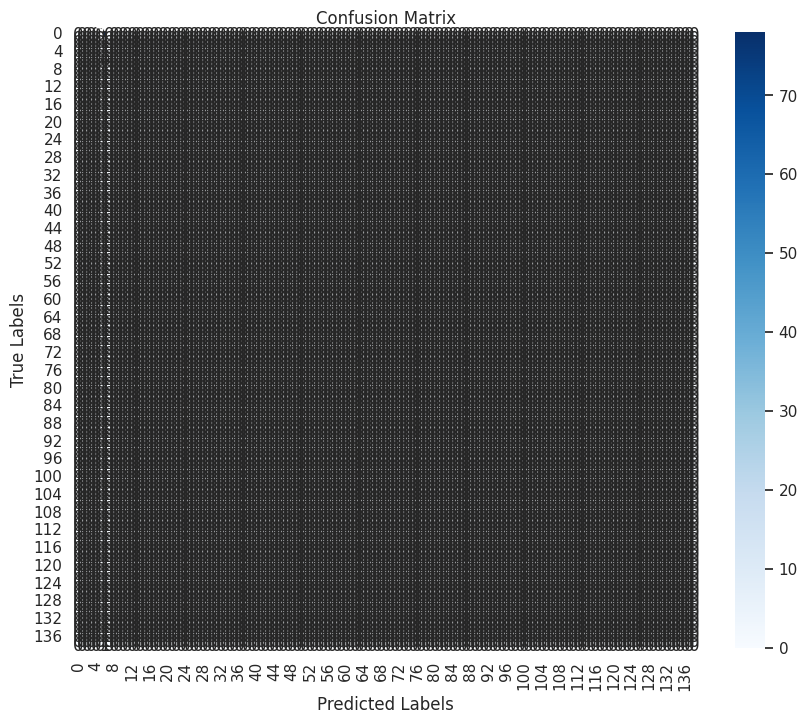

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Define the plot
plt.figure(figsize=(10, 8))

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels to the x-axis and the y-axis
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add a title to the heatmap
plt.title('Confusion Matrix')

# Show the plot
plt.show()


# Train the lemmatizer on the saved model

In [ ]:
# Step 1: Load the saved model
model_path = '/content/drive/MyDrive/Latin_text'

output_dir = '/content/drive/MyDrive/updated'
latin_text_dir = '/content/drive/MyDrive/data/latin_library_text'
lemmatizer_dir = '/content/drive/MyDrive/data/lemmatizer'
subwords_dir = '/content/drive/MyDrive/data/subword'
tokenizer_dir = '/content/drive/MyDrive/tokenized_data'

# Initialize LatinBERTTrainer with the directory paths
text_processor = LatinBERTTrainer(latin_text_dir, lemmatizer_dir, subwords_dir, tokenizer_dir=tokenizer_dir)


# Load files using the paths directly

lemmatizers = text_processor.load_files(lemmatizer_dir)


#device = text_processor.device
#new_model = load_model(model_path)
new_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Latin_text")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


No pre-tokenized data found at /content/drive/MyDrive/tokenized_data, starting tokenization from scratch.
Loading files
Loading text files from directory: /content/drive/MyDrive/data/lemmatizer
Found file: latin.lemmas.txt
Processing file: latin.lemmas.txt


In [ ]:
def process_lemmatizer_data(lemmatizer_dir):
    lemmatizer_data = []
    for root, dirs, files in os.walk(lemmatizer_dir):
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    for line in f:
                        inflected_form, lemma = line.strip().split()  # Modified line
                        lemmatizer_data.append((inflected_form, lemma))
    return lemmatizer_data



def tokenize_texts(texts, tokenizer, fixed_label):
    # Tokenize the texts and assign the fixed label
    tokenized_texts = text_processor.tokenizer(texts, padding='max_length', truncation=True, return_tensors='pt')
    labels = torch.full((len(texts),), fixed_label, dtype=torch.long)
    return {'input_ids': tokenized_texts['input_ids'], 'attention_mask': tokenized_texts['attention_mask'], 'labels': labels}



def data_collator(batch):
    # Collate the batch of data
    input_ids = pad_sequence([item['input_ids'] for item in batch], batch_first=True)
    attention_mask = pad_sequence([item['attention_mask'] for item in batch], batch_first=True)
    labels = torch.cat([item['labels'] for item in batch])
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}


In [ ]:
def custom_train(model, optimizer, train_dataloader, num_epochs=10, device="cuda"):
    model.to(device)
    model.train()
    accuracy = AccuracyMetric()
    loss_fn = Seq2SeqCrossEntropyLoss()

    for epoch in range(num_epochs):
        total_loss = 0.0
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)

        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            # Check if labels is empty or has an incorrect shape
            if labels.nelement() == 0 or labels.dim() == 0:
                continue

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            accuracy.update(logits, labels)
            loss = loss_fn(logits, labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        avg_loss = total_loss / len(train_dataloader)
        # Compute training accuracy
        train_acc = accuracy.compute()
        val_loss, val_acc = evaluate(model, train_dataloader, loss_fn, accuracy, device)

        # Print epoch, loss, and accuracy information
        print(f'Epoch {epoch+1}: Train Loss: {avg_loss:.4f}, Accuracy: {train_acc["accuracy"]:.4f}, '
              f'Precision: {train_acc["precision"]:.4f}, Recall: {train_acc["recall"]:.4f}, '
              f'F1-Score: {train_acc["f1"]:.4f}')
        # Update progress bar postfix with loss and accuracy information
        progress_bar.set_postfix({
            'train_loss': total_loss / len(train_dataloader),
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

    return model



def evaluate(model, dataloader, loss_fn, accuracy, device):
    model.eval()
    total_loss = 0.0
    accuracy.reset()

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            accuracy.update(logits, labels)
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

    val_loss = total_loss / len(dataloader)
    val_acc = accuracy.compute()

    return val_loss, val_acc

In [ ]:
# Step 2: Load and preprocess the lemmatizer data
# Cell 4: Load and preprocess data, tokenize, and train the model
#lemmatizer_dir = '/path/to/lemmatizer/data'
lemmatizer_texts = text_processor.load_files(lemmatizer_dir)

lemmatizer_data = process_lemmatizer_data(lemmatizer_dir)
lemmatizer_labels = text_processor.generate_labels_from_filenames(lemmatizer_dir)
fixed_label = 2146

tokenized_lemmatizer_data = tokenize_texts(lemmatizer_texts, text_processor.tokenizer, fixed_label)


lemmatizer_dataset = DataLoader(tokenized_lemmatizer_data, batch_size=16, collate_fn=data_collator)

# Step 4: Convert tokenized_lemmatizer_data to a TensorDataset
input_ids = tokenized_lemmatizer_data['input_ids']
attention_mask = tokenized_lemmatizer_data['attention_mask']
labels = tokenized_lemmatizer_data['labels']

lemmatizer_dataset = TensorDataset(input_ids, attention_mask, labels)

# Step 5: Create a DataLoader
lemmatizer_dataloader = DataLoader(lemmatizer_dataset, batch_size=16, shuffle=True)

# Step 6: Training
optimizer = AdamW(new_model.parameters(), lr=5e-5, weight_decay=0.01)
model = custom_train(new_model, optimizer, lemmatizer_dataloader, num_epochs=10, device="cpu")

# Step 7: Save the updated model
text_processor.save_model(model, output_dir)

Loading files
Loading text files from directory: /content/drive/MyDrive/data/lemmatizer
Found file: latin.lemmas.txt
Processing file: latin.lemmas.txt
Generated labels for filenames: {'latin.lemmas': 0}


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train Loss: 5.0327, Accuracy: 0.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 2: Train Loss: 4.4981, Accuracy: 0.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 3: Train Loss: 4.0290, Accuracy: 0.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 4: Train Loss: 3.4136, Accuracy: 0.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 5: Train Loss: 2.9546, Accuracy: 0.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 6: Train Loss: 2.6402, Accuracy: 0.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 7: Train Loss: 2.3682, Accuracy: 0.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 8: Train Loss: 2.0909, Accuracy: 0.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 9: Train Loss: 1.8338, Accuracy: 0.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 10: Train Loss: 1.6029, Accuracy: 0.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
Saved model in /content/drive/MyDrive/updated


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Place the model in evaluation mode
model = text_processor.model.eval()

# Collect all labels and predictions for the validation set
true_labels = []
predictions = []

with torch.no_grad():
    for batch in val_dataloader:
        inputs = batch['input_ids'].to(text_processor.device)
        labels = batch['labels'].to(text_processor.device)
        output = model(inputs)
        print(batch['input_ids'])
        print(batch['labels'])
        # The logits are the model outputs prior to activation function
        logits = output.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        # Store predictions and true labels
        batch_predictions = np.argmax(logits, axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)


tensor([[   101,  53866,  10251,  17247,  25032,  10112,  10108,  14327,  68756,
          53866,  17247,  45042,  10104,  14382,  12280,  25585,  11827,  99095,
          73658,  10147,  10209,  23310,  11671,  73658,  10147,    172,  28044,
          72517,  10104,  10477,  72517,  37913,  43125,  10162,  30168,  10104,
          10141,  10686,  63706,  28044,  11781,  10251,  59139,  38559,  13903,
          10133,  14382,  12212,  10251,  63706,  28044,  15471, 109680,  38559,
          13903,  10133,  63706,  28044,  15471,    177,  10477,  38559,  13903,
          10133,  26219,  16115,  92942,  38559,  13903,  10133,  17094,  54300,
          14101,    189,  10291,  53822,  10465,  10840,  19047,  16824,  10380,
          66047,    189,  11477,  53822,  10465,  64803,  12536,    189,  11477,
          10116,  53822,  10465,  32650,  51119,  14319,    177,  10686,  53822,
            102],
        [   101,  77586,  17039, 104767,  10219,  28439,  13527,  13951,  25504,
          

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1-Score: {f1:.4f}')

Validation Accuracy: 0.0000
Validation Precision: 0.0000
Validation Recall: 0.0000
Validation F1-Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


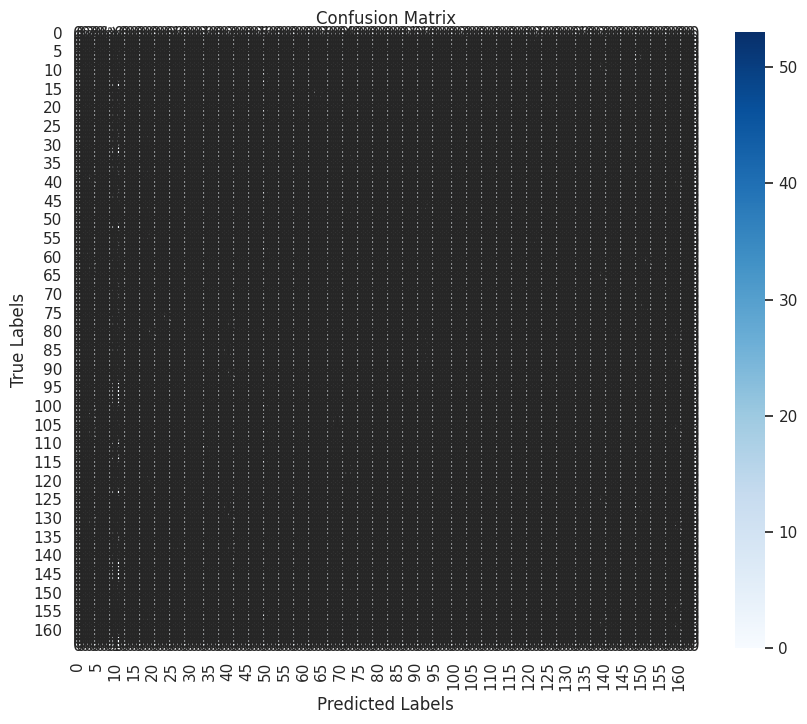

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Define the plot
plt.figure(figsize=(10, 8))

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels to the x-axis and the y-axis
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add a title to the heatmap
plt.title('Confusion Matrix')

# Show the plot
plt.show()


# **Stripping numerical values from filename**

In [ ]:
latin_text_dir = '/content/drive/MyDrive/data/test_latin_library_text'
lemmatizer_dir = '/content/drive/MyDrive/data/test_lemmatizer'
subwords_dir = '/content/drive/MyDrive/data/test_subword'
tokenizer_dir = '/content/drive/MyDrive/tokenized_data'

# Initialize LatinBERTTrainer with the directory paths
text_processor = LatinBERTTrainer(latin_text_dir, lemmatizer_dir, subwords_dir, tokenizer_dir=tokenizer_dir)


tokenizer = text_processor.tokenizer
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Latin_text")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


No pre-tokenized data found at /content/drive/MyDrive/tokenized_data, starting tokenization from scratch.


In [ ]:

def strip_numerical_values(filename):
    # Remove numerical values from the filename
    stripped_filename = ''.join([i for i in filename if not i.isdigit()])
    return stripped_filename

## **File Loading and tokenizer without back-translator**

In [ ]:
from sklearn.preprocessing import LabelEncoder

def load_and_tokenize_dataset(model_name="bert-base-multilingual-cased", max_length=512, test_size=0.1):
    # Load the dataset from Hugging Face
    dataset = load_dataset("grosenthal/latin_english_translation", split="train")
    print("Dataset loaded successfully.")

    # Load the tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_name)

    # Process the dataset to extract and classify filenames
    classified_dataset = []
    filenames = []
    label_encoder = LabelEncoder()

    for example in dataset:
        latin_text = example['la']
        english_text = example['en']

        # Extract the filename from the 'file' field, removing the path and extension
        file_path = example["file"]
        filename = file_path.split("\\")[-1].split(".")[0]
        stripped_filename = strip_numerical_values(filename)
        filenames.append(stripped_filename)

        # Tokenize the texts
        tokenized_texts = tokenizer(
            latin_text,
            english_text,
            padding="max_length",
            max_length=max_length,
            truncation="only_second",
            return_tensors="pt",
            return_token_type_ids=False,
            return_overflowing_tokens=True
        )
        classified_dataset.append(tokenized_texts)

    # Tokenize the labels
    label_encoded = label_encoder.fit_transform(filenames)

    # Assign encoded labels to the tokenized dataset
    for i, example in enumerate(classified_dataset):
        example["labels"] = label_encoded[i]

    # Split the tokenized dataset into train and validation sets
    print("Splitting tokenized dataset into train and validation sets...")
    train_data, val_data = train_test_split(classified_dataset, test_size=test_size, random_state=42)

    # Convert lists to datasets
    train_dataset = {'train': train_data}
    val_dataset = {'test': val_data}
    print("Tokenized dataset split into train and validation sets successfully.")

    return train_dataset['train'], val_dataset['test']

## **Loading the file with back-translation**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from translate import Translator

def create_translator():
    return Translator(to_lang="en", from_lang="la")

def translate_text(text, translator):
    translation = translator.translate(text)
    return translation

def load_and_tokenize_dataset(model_name="bert-base-multilingual-cased", max_length=512):
    # Load the dataset from Hugging Face
    dataset = load_dataset("grosenthal/latin_english_translation", split="train")
    print("Dataset loaded successfully.")

    # Load the tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_name)

    # Process the dataset to extract and classify filenames
    classified_dataset = []
    filenames = []
    label_encoder = LabelEncoder()

    # Initialize translator
    translator_to_en = create_translator()
    translator_to_la = Translator(to_lang="la", from_lang="en")

    for example in dataset:
        latin_text = example['la']
        english_text = example['en']

        # Perform back-translation
        translated_english = translate_text(latin_text, translator_to_en)
        back_translated_latin = translate_text(translated_english, translator_to_la)

        # Extract the filename from the 'file' field, removing the path and extension
        file_path = example["file"]
        filename = file_path.split("\\")[-1].split(".")[0]
        stripped_filename = strip_numerical_values(filename)
        filenames.append(stripped_filename)

        # Tokenize the texts
        tokenized_texts = tokenizer(
            latin_text,
            english_text,
            padding="max_length",
            max_length=max_length,
            truncation="only_second",
            return_tensors="pt",
            return_token_type_ids=False,
            return_overflowing_tokens=True
        )
        classified_dataset.append(tokenized_texts)

        # Tokenize the back-translated Latin text and English text
        back_translated_tokenized_texts = tokenizer(
            back_translated_latin,
            english_text,
            padding="max_length",
            max_length=max_length,
            truncation="only_second",
            return_tensors="pt",
            return_token_type_ids=False,
            return_overflowing_tokens=True
        )
        classified_dataset.append(back_translated_tokenized_texts)

    # Tokenize the labels
    label_encoded = label_encoder.fit_transform(filenames)

    # Assign encoded labels to the tokenized dataset
    for i, example in enumerate(classified_dataset):
        example["labels"] = label_encoded[i // 2]

    # Split the tokenized dataset into train and validation sets
    print("Splitting tokenized dataset into train and validation sets...")
    train_data, val_data = train_test_split(classified_dataset, test_size=0.1, random_state=42)

    # Convert lists to datasets
    train_dataset = {'train': train_data}
    val_dataset = {'test': val_data}
    print("Tokenized dataset split into train and validation sets successfully.")

    return train_dataset['train'], val_dataset['test']

In [ ]:
# Load and tokenize the dataset
train_datasets, val_datasets = load_and_tokenize_dataset()
# Check the structure of the first element in train_datasets
print("Keys of the first element in train_datasets:", train_datasets[0].keys())
print(train_datasets[:1])
print(val_datasets[:1])
# Check the size of the train and validation datasets
print("Size of train dataset:", len(train_datasets))
print(type(train_datasets))
print("Size of validation dataset:", len(val_datasets))
print(type(val_datasets))


Dataset loaded successfully.
Splitting tokenized dataset into train and validation sets...
Tokenized dataset split into train and validation sets successfully.
Keys of the first element in train_datasets: dict_keys(['overflowing_tokens', 'num_truncated_tokens', 'input_ids', 'attention_mask', 'labels'])
[{'overflowing_tokens': tensor([], size=(1, 0)), 'num_truncated_tokens': tensor([-438]), 'input_ids': tensor([[  101, 91729, 10446, 11735, 10493, 13048, 10147, 38559, 10563, 10493,
         11244, 13000, 47097, 43197, 10147, 10628, 87601, 64022, 12132, 11924,
         15696, 65150, 20722, 10291, 14382, 11645, 10131, 10106, 35844, 10131,
         10106, 81432,   102, 16040, 11858, 10146,   169, 53211,   117, 10473,
         17427, 10108,   169, 53211,   117,   169, 10992, 42492, 10129, 15739,
           117, 17491, 10114, 10911,   119, 16976, 14796, 13172, 10798, 10114,
         10105, 10112,   117, 11408, 10106, 10105, 58768, 38806, 10111, 10106,
         10105, 13440,   136,   102,     

In [ ]:
max_label_train = max([example["labels"] for example in train_datasets])
min_label_train = min([example["labels"] for example in val_datasets])
print("Max label (train):", max_label_train)
print("Min label (train):", min_label_train)

# Print the maximum and minimum labels in the validation dataset
max_label_val = max([example["labels"] for example in val_datasets])
min_label_val = min([example["labels"] for example in val_datasets])
print("Max label (validation):", max_label_val)
print("Min label (validation):", min_label_val)

Max label (train): 115
Min label (train): 0
Max label (validation): 115
Min label (validation): 0


In [ ]:
# Load the model from Google Drive
#model_path = text_processor.load_model("/content/drive/MyDrive/Latin_text")
# Load the model and tokenizer
#tokenizer = BertForSequenceClassification(model_name)
latin_text_dir = '/content/drive/MyDrive/data/test_latin_library_text'
lemmatizer_dir = '/content/drive/MyDrive/data/test_lemmatizer'
subwords_dir = '/content/drive/MyDrive/data/test_subword'
tokenizer_dir = '/content/drive/MyDrive/tokenized_data'

# Initialize LatinBERTTrainer with the directory paths
text_processor = LatinBERTTrainer(latin_text_dir, lemmatizer_dir, subwords_dir, tokenizer_dir=tokenizer_dir)


tokenizer = text_processor.tokenizer
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Latin_text")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


No pre-tokenized data found at /content/drive/MyDrive/tokenized_data, starting tokenization from scratch.


Converting to Datasets and getting them ready for Training

In [ ]:
train_datasets =Dataset.from_list(train_datasets)
val_datasets =Dataset.from_list(val_datasets)
print("Type of train_dataset (before Trainer):", type(train_datasets))
print("Type of val_dataset (before Trainer):", type(val_datasets))



Type of train_dataset (before Trainer): <class 'datasets.arrow_dataset.Dataset'>
Type of val_dataset (before Trainer): <class 'datasets.arrow_dataset.Dataset'>


In [ ]:
# Verify the model's configuration
print(model.config)

BertConfig {
  "_name_or_path": "/content/drive/MyDrive/Latin_text",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_3

In [ ]:
class BertGRUForSequenceClassification(nn.Module):
    def __init__(self, num_labels):
        super(BertGRUForSequenceClassification, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Latin_text")
        self.gru = nn.GRU(input_size=self.bert.config.hidden_size, hidden_size=256, num_layers=1, batch_first=True)
        self.classifier = nn.Linear(256, num_labels)

    def forward(self, input_ids, attention_mask):
        # Ensure output_hidden_states is set to True to get the hidden states
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        # Access the last hidden state
        last_hidden_state = bert_outputs.hidden_states[-1]
        gru_outputs, _ = self.gru(last_hidden_state)
        gru_outputs = gru_outputs[:, -1, :] # Use the last hidden state of GRU
        logits = self.classifier(gru_outputs)
        return logits



In [ ]:
# Extract filenames from train_datasets
labels = []
print("Keys of the first element in train_datasets:", train_datasets[0].keys())
print(f"Type of the dataset: {type(train_datasets)}")
for example in train_datasets:
    label = example['labels']
    labels.append(label)
print("Labels:", labels)

# Encode the labels using LabelEncoder
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(labels)

# Print the encoded labels
print("Encoded labels:", label_encoded)

# Print the unique classes and their counts
unique_labels, label_counts = np.unique(label_encoded, return_counts=True)
print("Unique labels:", unique_labels)
print("Label counts:", label_counts)

# Determine the number of unique labels
num_labels = len(unique_labels)
print("Number of unique labels:", num_labels)


Keys of the first element in train_datasets: dict_keys(['overflowing_tokens', 'num_truncated_tokens', 'input_ids', 'attention_mask', 'labels'])
Type of the dataset: <class 'datasets.arrow_dataset.Dataset'>
Labels: [115, 30, 91, 68, 115, 115, 115, 115, 115, 27, 114, 89, 4, 115, 37, 108, 10, 27, 115, 12, 115, 115, 115, 92, 99, 114, 115, 93, 115, 115, 84, 115, 91, 115, 84, 12, 115, 115, 68, 83, 115, 26, 115, 85, 115, 115, 115, 74, 31, 99, 115, 115, 115, 107, 107, 115, 94, 93, 115, 0, 115, 26, 32, 115, 115, 12, 68, 115, 84, 0, 115, 36, 115, 115, 115, 115, 113, 79, 37, 108, 0, 115, 115, 0, 115, 32, 32, 56, 115, 6, 115, 115, 115, 108, 107, 89, 1, 107, 84, 115, 84, 111, 35, 115, 114, 77, 15, 68, 78, 115, 94, 94, 68, 32, 26, 115, 99, 89, 115, 66, 115, 34, 0, 115, 115, 115, 84, 115, 91, 70, 115, 115, 115, 115, 115, 27, 115, 89, 115, 27, 115, 99, 0, 115, 99, 48, 115, 0, 115, 1, 37, 114, 29, 108, 115, 0, 83, 86, 115, 115, 94, 115, 77, 115, 115, 115, 62, 70, 115, 111, 115, 37, 70, 83, 0, 89, 0, 0,

In [ ]:
def collate_fn(batch):
    # Truncate the sequences to a maximum length
    max_length = 600

    input_ids = [torch.tensor(item['input_ids'][:max_length]) for item in batch]
    attention_mask = [torch.tensor(item['attention_mask'][:max_length]) for item in batch]
    labels = [item['labels'] for item in batch]

    # Padding the sequences
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=text_processor.tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels = torch.tensor(labels)

    # Ensure input and target tensors have the same batch size
    batch_size = input_ids.size(0)
    labels = labels[:batch_size]
    # Move the tensors to the GPU and remove the extra dimension
    input_ids = input_ids.to(text_processor.device)
    attention_mask = attention_mask.to(text_processor.device)
    labels = labels.to(text_processor.device)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}


def evaluate(dataloader, loss_fn, accuracy):
    total_loss = 0.0
    accuracy.reset()

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(text_processor.device)
            attention_mask = batch['attention_mask'].to(text_processor.device)
            labels = batch['labels'].to(text_processor.device)

            # Ensure input_ids and attention_mask are 2D [batch_size, sequence_length]
            if input_ids.dim() > 2:
                input_ids = input_ids.squeeze(1)
            if attention_mask.dim() > 2:
                attention_mask = attention_mask.squeeze(1)
            outputs = model(input_ids, attention_mask=attention_mask)

            logits = outputs.logits

            loss = loss_fn(logits, labels)
            total_loss += loss.item()


            accuracy.update(logits, labels)

    avg_loss = total_loss / len(dataloader.dataset)
    acc = accuracy.compute()

    return avg_loss, acc



# Update the DataLoader initialization
train_dataloader = DataLoader(train_datasets, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_datasets, batch_size=16, collate_fn=collate_fn)


num_epochs = 2
optimizer = AdamW(text_processor.model.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=len(train_datasets) * num_epochs)

# Define the loss function
loss_fn = Seq2SeqCrossEntropyLoss(ignore_index=-1)

# Define additional metrics
accuracy = Accuracy(ignore_index=-1)
# Move the model to the GPU
model.to(text_processor.device)
# Custom training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Initialize loss accumulator
    total_loss = 0.0
    all_preds = []
    all_labels = []

    # Reset metric states
    accuracy.reset()

    # Create a tqdm progress bar for the training dataset
    train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")

    # Iterate over training dataset
    for batch in train_progress_bar:
        # Move data to desired device (CPU or GPU)
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        # Check the shape of input_ids
        if input_ids.dim() == 3:
            input_ids = input_ids.squeeze(1)
        if attention_mask.dim() == 3:
            attention_mask = attention_mask.squeeze(1)

        # We need to clear any previously calculated gradients before performing a backward pass
        model.zero_grad()

        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        accuracy.add_batch(predictions=logits, references=labels)

        # Compute loss
        loss = loss_fn(logits, labels)

        # Backward pass and parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Accumulate loss
        total_loss += loss.item()


    # Compute average loss for the epoch
    avg_loss = total_loss / len(train_datasets)

    # Compute training accuracy
    train_acc = accuracy.compute()

    # Evaluate the model on the validation dataset
    text_processor.model.eval()
    val_loss, val_acc = evaluate(val_dataloader, loss_fn, accuracy)


    # Update the progress bar description with loss and accuracy
    train_progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {loss.item():.4f}, Accuracy: {accuracy.compute():.4f}")
    # Print training and validation progress
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Save the model and tokenizer
text_processor.model.save_pretrained("/content/drive/MyDrive/updated")
text_processor.tokenizer.save_pretrained("/content/drive/MyDrive/updated")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/2 - Training: 100%|██████████| 5588/5588 [1:13:37<00:00,  1.26it/s]


Epoch 1/2, Train Loss: 0.6236, Val Loss: 0.6266, Val Accuracy: 0.0001


Epoch 2/2 - Training: 100%|██████████| 5588/5588 [1:13:41<00:00,  1.26it/s]


Epoch 2/2, Train Loss: 0.6235, Val Loss: 0.6271, Val Accuracy: 0.0000


('/content/drive/MyDrive/updated/tokenizer_config.json',
 '/content/drive/MyDrive/updated/special_tokens_map.json',
 '/content/drive/MyDrive/updated/vocab.txt',
 '/content/drive/MyDrive/updated/added_tokens.json')

# **Tests**




In [ ]:
model_path = "/content/drive/MyDrive/updated"
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
print(model.config)

BertConfig {
  "_name_or_path": "/content/drive/MyDrive/updated",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",

In [ ]:
from transformers import BertTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Load the model
model_path = "/content/drive/MyDrive/updated"
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)

# Load and tokenize the dataset
def load_and_tokenize_dataset(model_name=model, max_length=512, test_size=0.1):
    # Load the dataset from Hugging Face
    dataset = load_dataset("grosenthal/latin_english_translation", split="test")
    print("Dataset loaded successfully.")

    # Initialize label encoder
    label_encoder = LabelEncoder()

    # Prepare dataset
    data = []
    filenames = [os.path.basename(example["file"]) for example in dataset]  # Extract file names
    encoded_labels = label_encoder.fit_transform(filenames)
    print("Encoded Labels:", encoded_labels)
    for i, example in enumerate(dataset):
        # Tokenize text
        tokenized_input = tokenizer(
            example['la'], example['en'],
            max_length=max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        # Build dataset item
        data.append({
            'input_ids': tokenized_input['input_ids'].squeeze(0),  # Remove batch dimension
            'attention_mask': tokenized_input['attention_mask'].squeeze(0),
            'labels': torch.tensor(encoded_labels[i])  # Ensure labels are tensors
        })

    # Split the dataset
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)

    return DataLoader(CustomDataset(train_data), batch_size=16, shuffle=True), \
           DataLoader(CustomDataset(test_data), batch_size=16, shuffle=False), tokenizer

# Define evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            labels = batch['labels'].to(model.device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels

# Load and tokenize the dataset
train_dataloader, test_dataloader, tokenizer = load_and_tokenize_dataset()

# Evaluate the model
test_predictions, test_labels = evaluate_model(model, test_dataloader)

# Compute confusion matrix and classification report
conf_matrix = confusion_matrix(test_labels, test_predictions)
classification_rep = classification_report(test_labels, test_predictions)

# Print results
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


Dataset loaded successfully.
Encoded Labels: [102 210  52 ...  31 210  90]

Confusion Matrix:
[[0 0 0 ... 2 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       2.0
           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       1.0
           7       0.00      0.00      0.00       2.0
           8       0.00      0.00      0.00       1.0
          13       0.00      0.00      0.00       1.0
          15       0.00      0.00      0.00       2.0
          17       0.00      0.00      0.00       1.0
          36       0.00      0.00      0.00       1.0
          38       0.00      0.00      0.00       2.0
          39       0.00      0.00      0.00       1.0
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
from transformers import BertTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np

# Function to prepare and tokenize the dataset
def prepare_and_tokenize_dataset(split_type="test", model_path="/content/drive/MyDrive/updated"):
    # Load the dataset from Hugging Face
    dataset = load_dataset("grosenthal/latin_english_translation", split=split_type)
    tokenizer = BertTokenizer.from_pretrained(model_path)

    # Tokenize the dataset
    tokenized_data = tokenizer(dataset['la'], dataset['en'],
                               padding=True, truncation=True, return_tensors="pt", max_length=512)

    # Prepare DataLoader
    dataset = torch.utils.data.TensorDataset(tokenized_data['input_ids'], tokenized_data['attention_mask'])
    dataloader = DataLoader(dataset, batch_size=16)

    return dataloader

# Function to evaluate the model
def evaluate_language_model(model, dataloader):
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask = batch
            input_ids = input_ids.to(model.device)
            attention_mask = attention_mask.to(model.device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())

    return all_predictions

# Load model
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/updated")
#model.to('cuda')

# Prepare and tokenize the dataset
test_dataloader = prepare_and_tokenize_dataset()

# Evaluate the model
predictions = evaluate_language_model(model, test_dataloader)

# Example metric: Accuracy
accuracy = accuracy_score(np.ones(len(predictions)), predictions)  # Dummy true labels, replace with actual labels
print(f"Model accuracy: {accuracy:.4f}")



Model accuracy: 0.0000


# Testing against actually predictions

In [37]:
from datasets import load_dataset
from transformers import BertTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load and preprocess the test dataset
test_dataset = [
      {"lt": "post haec ambulabat Iesus in Galileaeam non enim volebat in Iudaeam ambulare quia quaerebant eum Iudaei interficere",
     "en": "After these things, Jesus walked in Galilee: for he would not walk in Judea, because the Jews sought to kill him."}

]

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

test_latin_sentences = []
test_english_translations = []

for example in test_dataset:
    test_latin_sentences.append(example["lt"])
    test_english_translations.append(example["en"])

test_encodings = tokenizer(test_latin_sentences, padding=True, truncation=True, return_tensors="pt")

# Load your trained model
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/updated")

# Make predictions on the test dataset
predicted_translations = []

with torch.no_grad():
    outputs = model(**test_encodings)
    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1)

    for label in predicted_labels:
        predicted_translations.append(tokenizer.decode(label))

# Calculate evaluation metrics
accuracy = accuracy_score([test_english_translations[0]], predicted_translations)
precision = precision_score([test_english_translations[0]], predicted_translations, average="weighted")
recall = recall_score([test_english_translations[0]], predicted_translations, average="weighted")
f1 = f1_score([test_english_translations[0]], predicted_translations, average="weighted")

print("Predicted translation:", predicted_translations[0])
print("Actual translation:", test_english_translations[0])
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Predicted translation: ਜ
Actual translation: After these things, Jesus walked in Galilee: for he would not walk in Judea, because the Jews sought to kill him.
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1-score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
from datasets import load_dataset
import pandas as pd
import csv

# Load the dataset from Hugging Face
dataset_name = "grosenthal/latin_english_translation"
dataset = load_dataset(dataset_name, split="test")

# Define the output CSV file path
output_file = "latin_english_dataset.csv"

# Open the CSV file in write mode
with open(output_file, "w", newline="", encoding="utf-8") as file:
    # Create a CSV writer
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(["latin", "english"])

    # Iterate over the dataset and write each example to the CSV file
    for example in dataset:
        latin_text = example["la"]
        english_text = example["en"]
        writer.writerow([latin_text, english_text])

print(f"Dataset saved to {output_file}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/99343 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Dataset saved to latin_english_dataset.csv


In [ ]:
import csv
from transformers import BertTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load and preprocess the test dataset from CSV file
test_dataset_file = "/content/drive/MyDrive/latin_english_dataset.csv"

def load_dataset(file_path, batch_size=32):
    test_latin_sentences = []
    test_english_translations = []

    with open(file_path, "r") as file:
        reader = csv.DictReader(file)
        for row in reader:
            test_latin_sentences.append(row["latin"])
            test_english_translations.append(row["english"])

    for i in range(0, len(test_latin_sentences), batch_size):
        batch_latin_sentences = test_latin_sentences[i:i+batch_size]
        batch_english_translations = test_english_translations[i:i+batch_size]
        yield batch_latin_sentences, batch_english_translations

# Load your trained model
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/updated")
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Make predictions on the test dataset
predicted_translations = []
true_translations = []

for batch_latin_sentences, batch_english_translations in load_dataset(test_dataset_file):
    batch_encodings = tokenizer(batch_latin_sentences, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**batch_encodings)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)

        for label in predicted_labels:
            predicted_translations.append(tokenizer.decode(label))

    true_translations.extend(batch_english_translations)

# Calculate evaluation metrics
cm = confusion_matrix(true_translations, predicted_translations, labels=np.unique(true_translations))

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  # Increase figure size for better visibility
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(true_translations), yticklabels=np.unique(true_translations))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print or calculate per-class metrics
precision = precision_score(true_translations, predicted_translations, average=None)  # None for class-wise
recall = recall_score(true_translations, predicted_translations, average=None)
f1 = f1_score(true_translations, predicted_translations, average=None)
print("Precision by class:", precision)
print("Recall by class:", recall)
print("F1-score by class:", f1)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load and preprocess the test dataset
test_dataset = load_dataset("/content/drive/MyDrive/latin_english.csv")  # Replace with your test dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

test_latin_words = []
test_english_translations = []

for example in test_dataset:
    test_latin_words.append(example["latin_word"])
    test_english_translations.append(example["english_translation"])

test_encodings = tokenizer(test_latin_words, padding=True, truncation=True, return_tensors="pt")

# Load your trained model
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/updated")

# Make predictions on the test dataset
predicted_translations = []

with torch.no_grad():
    outputs = model(**test_encodings)
    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1)

    for label in predicted_labels:
        predicted_translations.append(tokenizer.decode(label))

# Calculate evaluation metrics
accuracy = accuracy_score(test_english_translations, predicted_translations)
precision = precision_score(test_english_translations, predicted_translations, average="weighted")
recall = recall_score(test_english_translations, predicted_translations, average="weighted")
f1 = f1_score(test_english_translations, predicted_translations, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)